# example code for training and evaluating hmm models


## define imports and constants


In [2]:
import sys
from pathlib import Path

# get project root for file paths and add project root to python path so imports work from notebooks folder
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from hmm.preprocess import build_sequences_from_csv
from hmm.hmm_model import train_supervised_hmm, sequence_accuracy
from hmm.hmm_viterbi import viterbi_on_sequences

import numpy as np
import matplotlib.pyplot as plt

# constants
DATA_PATH = str(PROJECT_ROOT / "data" / "allseasons.csv")  # path where game data is stored
HOLDOUT_SEASONS = (2018, 2024)  # test set seasons
NUM_STATES = 2  # 0 = loss, 1 = win

# notebook plotting defaults
plt.style.use("seaborn-v0_8")
%matplotlib inline


## load and inspect sequences


In [3]:
# build sequences using specified holdout seasons
(
    train_states,
    train_obs,
    test_states,
    test_obs,
    train_seasons,
    test_seasons,
) = build_sequences_from_csv(
    DATA_PATH,
    holdout_seasons=HOLDOUT_SEASONS,
)

print(f"num train sequences: {len(train_states)}")
print(f"num test sequences: {len(test_states)}")

# compute basic length statistics for sequences
train_lengths = [s.size for s in train_states]
test_lengths = [s.size for s in test_states]

print()
print("train sequence length stats (min / max / mean):",
      np.min(train_lengths), np.max(train_lengths), np.mean(train_lengths))
print("test sequence length stats (min / max / mean):",
      np.min(test_lengths), np.max(test_lengths), np.mean(test_lengths))


num train sequences: 686
num test sequences: 60

train sequence length stats (min / max / mean): 63 84 80.08746355685132
test sequence length stats (min / max / mean): 81 83 81.9


## train supervised hmm


In [4]:
# train supervised hmm (mle using known win/loss states)
pi, A, B = train_supervised_hmm(
    state_sequences=train_states,
    obs_sequences=train_obs,
    num_states=NUM_STATES,
)

print("initial state distribution (pi):")
print(pi)
print()

print("transition matrix (A):")
print(A)
print()

print("emission matrix (B):")
print(B)
print()

print("shapes -> pi:", pi.shape, ", A:", A.shape, ", B:", B.shape)


initial state distribution (pi):
[0.49127907 0.50872093]

transition matrix (A):
[[0.54212292 0.45787708]
 [0.45811682 0.54188318]]

emission matrix (B):
[[3.42129208e-03 2.74795268e-01 6.86878981e-01 3.48316652e-02
  7.27934486e-05]
 [1.09190173e-04 3.45404914e-02 6.89208371e-01 2.73703367e-01
  2.43858053e-03]]

shapes -> pi: (2,) , A: (2, 2) , B: (2, 5)


## run viterbi decoding on test data and compute accuracy


In [5]:
# run viterbi on test observation sequences
pred_paths = viterbi_on_sequences(
    emissions=B,
    initials=pi,
    transitions=A,
    obs_sequences=test_obs,
)

# compute overall test accuracy
overall_acc = sequence_accuracy(test_states, pred_paths)
print("overall test accuracy:", overall_acc)

# compute per-sequence accuracies and keep track of seasons and indices
per_seq_accs = []
per_seq_seasons = []
per_seq_indices = []

for idx, (season, y_true, y_pred) in enumerate(
    zip(test_seasons, test_states, pred_paths)
):
    if y_true.size == 0 or y_pred.size == 0:
        continue
    T = min(y_true.size, y_pred.size)
    acc = np.mean(y_true[:T] == y_pred[:T])
    per_seq_accs.append(acc)
    per_seq_seasons.append(season)
    per_seq_indices.append(idx)

per_seq_accs = np.array(per_seq_accs)
per_seq_seasons = np.array(per_seq_seasons)
per_seq_indices = np.array(per_seq_indices, dtype=int)

print("mean per-sequence accuracy:", per_seq_accs.mean())
print("median per-sequence accuracy:", np.median(per_seq_accs))


overall test accuracy: 0.6442816442816443
mean per-sequence accuracy: 0.6442729968352786
median per-sequence accuracy: 0.6463414634146342


## visualize per-sequence accuracy distribution


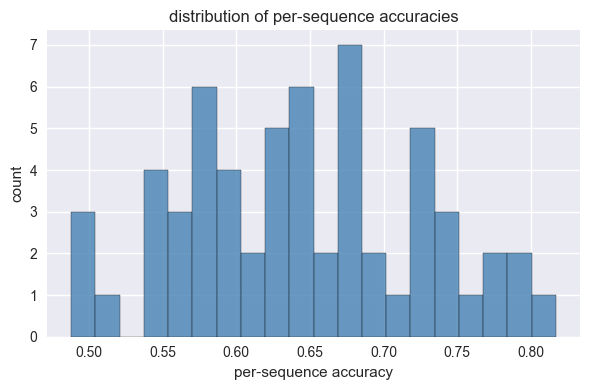

In [6]:
# plot histogram of per-sequence accuracies
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(per_seq_accs, bins=20, color="steelblue", edgecolor="black", alpha=0.8)
ax.set_xlabel("per-sequence accuracy")
ax.set_ylabel("count")
ax.set_title("distribution of per-sequence accuracies")
plt.tight_layout()
plt.show()


## confusion matrix of predicted vs true state


confusion matrix (rows = true, cols = predicted):
[[1278 1179]
 [ 569 1888]]


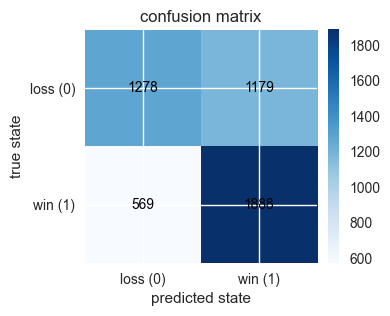

In [7]:
# build confusion matrix over all test games
confusion = np.zeros((NUM_STATES, NUM_STATES), dtype=int)

for y_true, y_pred in zip(test_states, pred_paths):
    if y_true.size == 0 or y_pred.size == 0:
        continue
    T = min(y_true.size, y_pred.size)
    for t in range(T):
        confusion[y_true[t], y_pred[t]] += 1

print("confusion matrix (rows = true, cols = predicted):")
print(confusion)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(confusion, cmap="Blues")

ax.set_xticks(range(NUM_STATES))
ax.set_yticks(range(NUM_STATES))
ax.set_xticklabels(["loss (0)", "win (1)"])
ax.set_yticklabels(["loss (0)", "win (1)"])
ax.set_xlabel("predicted state")
ax.set_ylabel("true state")
ax.set_title("confusion matrix")

for i in range(NUM_STATES):
    for j in range(NUM_STATES):
        ax.text(j, i, confusion[i, j], ha="center", va="center", color="black")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


## example season: true vs predicted states


In [ ]:
# select an example test sequence to visualize
example_idx = 0

true_seq = test_states[example_idx]
pred_seq = pred_paths[example_idx]

T = min(true_seq.size, pred_seq.size)
x = np.arange(T)

fig, ax = plt.subplots(figsize=(10, 3))
ax.step(x, true_seq[:T], where="post", label="true state", linewidth=2)
ax.step(x, pred_seq[:T] + 0.02, where="post", label="predicted state", linestyle="--")

ax.set_ylim(-0.2, 1.2)
ax.set_yticks([0, 1])
ax.set_yticklabels(["loss", "win"])
ax.set_xlabel("game index in season")
ax.set_title("example test sequence: true vs predicted states")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


## best and worst sequences by accuracy


In [ ]:
# sort sequences by accuracy and print a few best and worst examples
k = 5  # number of sequences to display in each group

if per_seq_accs.size == 0:
    print("no non-empty test sequences to display")
else:
    sorted_idx = np.argsort(per_seq_accs)
    k = min(k, per_seq_accs.size)

    print("worst sequences:")
    for rank, idx in enumerate(sorted_idx[:k], start=1):
        seq_acc = per_seq_accs[idx]
        season = per_seq_seasons[idx]
        original_index = per_seq_indices[idx]
        seq_len = test_states[original_index].size
        print(
            f"  {rank}. season {season}, index {original_index}, "
            f"length {seq_len}, accuracy {seq_acc:.3f}"
        )

    print()
    print("best sequences:")
    for rank, idx in enumerate(sorted_idx[-k:][::-1], start=1):
        seq_acc = per_seq_accs[idx]
        season = per_seq_seasons[idx]
        original_index = per_seq_indices[idx]
        seq_len = test_states[original_index].size
        print(
            f"  {rank}. season {season}, index {original_index}, "
            f"length {seq_len}, accuracy {seq_acc:.3f}"
        )


## aggregate performance by season


In [ ]:
# compute per-season mean accuracy
if per_seq_accs.size == 0:
    print("no per-sequence accuracies available for season aggregation")
else:
    unique_seasons = np.unique(per_seq_seasons)
    season_means = []
    season_counts = []

    print("per-season accuracy summary:")
    for season in unique_seasons:
        mask = per_seq_seasons == season
        season_accs = per_seq_accs[mask]
        mean_acc = season_accs.mean()
        count = season_accs.size
        season_means.append(mean_acc)
        season_counts.append(count)
        print(
            f"  season {season}: mean accuracy {mean_acc:.3f} "
            f"over {count} sequences"
        )

    season_means = np.array(season_means)
    season_counts = np.array(season_counts)


In [ ]:
# bar chart of mean accuracy by season
if per_seq_accs.size == 0:
    print("no data to plot for per-season accuracy")
else:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(unique_seasons, season_means, color="steelblue", edgecolor="black")
    ax.set_xlabel("season start year")
    ax.set_ylabel("mean per-sequence accuracy")
    ax.set_title("hmm performance by season")
    plt.tight_layout()
    plt.show()
